In [1]:
import pandas as pd
import urllib
from sqlalchemy import create_engine
import numpy as np
from datetime import date as dt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
params = urllib.parse.quote_plus(
    r"Driver={SQL Server Native Client 11.0};"
    r"Server=BARAD-DUR;"
    r"Database=Endeavor;"
    r"trusted_connection=yes;"
    r"fast_executemany=True;"
)

engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

In [3]:
query = "select * from hockey_stats where home_team = 'bowling-green' or away_team = 'bowling-green'"

In [4]:
data = pd.read_sql(query, engine)

In [5]:
data["game_date"] = pd.to_datetime(data["game_date"])
data["day"] = data["game_date"].dt.day
data["month"] = data["game_date"].dt.month
data['year'] = data["game_date"].dt.year

In [6]:
data["win"] = np.where(data['home_score'] > data["away_score"], 1, 0)
data["loss"] = np.where(data['home_score'] < data["away_score"], 1, 0)
data["tie"] = np.where(data['home_score'] == data["away_score"], 1, 0)

In [7]:
X = data[["home_score", "away_score"]]
y = data["win"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .3)

In [9]:
rfc = RandomForestClassifier()

In [10]:
params = {
        "n_estimators": [100, 1000, 1500],
        "criterion": ["gini", "entropy"],
        "max_depth": [1, 5, 10],
        "max_features": ["sqrt", "log2"],
        "n_jobs": [-1]
    }

In [11]:
grid = GridSearchCV(rfc, params).fit(X_train, y_train)
grid_df = pd.DataFrame(grid.cv_results_)

In [12]:
best_model = grid_df.loc[:"mean_test_score"].max()

C:\Users\natha\AppData\Local\Temp\ipykernel_18328\3501407989.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  best_model = grid_df.loc[:"mean_test_score"].max()


In [13]:
# Train best model
best_rfc = RandomForestClassifier(
    n_estimators=best_model.param_n_estimators,
    criterion=best_model.param_criterion,
    max_depth=best_model.param_max_depth,
    max_features=best_model.param_max_features,
    n_jobs=best_model.param_n_jobs
).fit(X_train, y_train)

y_pred = best_rfc.predict(X)

[Text(0, 0.5, 'Positive'), Text(0, 1.5, 'Negative')]

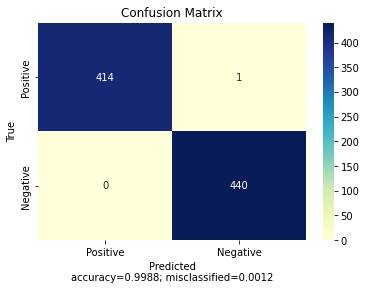

In [14]:
# get results
con_mat = confusion_matrix(y, y_pred)
accuracy = np.trace(con_mat) / np.sum(con_mat).astype("float")
misclassified = 1 - accuracy

ax = plt.subplot()
sns.heatmap(con_mat, annot=True, fmt="d", cmap="YlGnBu")
plt.title(label="Confusion Matrix")
plt.xlabel(
    "Predicted\naccuracy={:0.4f}; misclassified={:0.4f}".format(
        accuracy, misclassified
    )
)
plt.ylabel("True")
ax.xaxis.set_ticklabels(["Positive", "Negative"])
ax.yaxis.set_ticklabels(["Positive", "Negative"])